In [ ]:
# Based on https://neuro.cs.ut.ee/what-neural-networks-actually-do/

In [ ]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import logging
import inspect

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import animation
from IPython.display import HTML, display

from keras.models import Model
from keras.layers import Dense, Input

import keras.backend as K
import tensorflow as tf

In [ ]:
class Activation(keras.layers.Layer):
  def __init__(self, activation_functions=[keras.activations.relu, keras.activations.tanh, keras.activations.sigmoid]):
    super(Activation, self).__init__()
    self.activation_functions = activation_functions
    self.units = len(activation_functions)
    self.softmax = keras.layers.Softmax(axis=0)

  def get_config(self):
    base_config = super(Activation, self).get_config()
    base_config['activation_functions'] = self.activation_functions
    return base_config

  def build(self, input_shape):
    self.w = self.add_weight(
        name="activation_weight",
        shape=(self.units, *list(map(lambda shape: shape if shape is not None else 1, input_shape))),
        initializer="zeros",
        trainable=True,
    )

  def call(self, inputs):
    outputs = []
    for activation_function in self.activation_functions:
      outputs.append(activation_function(inputs))
      
    tensor_outputs = tf.convert_to_tensor(outputs)
    softmax_weights = self.softmax(self.w)
    multiplied_by_weights = tensor_outputs * softmax_weights
    return tf.math.reduce_sum(multiplied_by_weights, axis=0)

In [ ]:
models_path = "drive/MyDrive/master-thesis/models/experiments-basic-neuron/"

In [ ]:
def plot_results(model, width=5, height=4):
  for layer in model.layers:
    config = layer.get_config()
    if layer.get_config()['name'].split('_')[0] == 'activation':
      weights = np.array(layer.get_weights()[0])
      n_nodes = len(weights[0,0])
      plt.figure(figsize=(width * n_nodes, height), dpi=300)
      for i in range(n_nodes):
        weights_for_fn = weights[:, :, i]
        softmax_weights = keras.activations.softmax(tf.convert_to_tensor(weights_for_fn), axis=0)
        labels = list(map(lambda fn: keras.activations.serialize(fn)[:7], layer.activation_functions))
        plt.subplot(1, n_nodes, i + 1)
        plt.bar(labels, softmax_weights[:,0])
        plt.title(f"Hidden node {i}")
      plt.show() 

In [ ]:
def run_test(activation_functions=[keras.activations.relu, keras.activations.tanh, keras.activations.sigmoid, K.cos], n_nodes=3, iterations=100):
  X = np.linspace(-10, 10, 50)[:,np.newaxis]
  y_true = np.sin(X)
  noise = np.random.normal(scale=0.15, size=(len(y_true), 1))
  y_target = y_true + noise

  # --------------------------------------

  x = Input(shape=(1,))
  h = Dense(n_nodes)(x)
  a = Activation(activation_functions=activation_functions)(h)
  y = Dense(1)(a)
  model_train = Model(x, y)
  model_train.compile(optimizer=keras.optimizers.Adam(0.5), loss='mse')
  
  # --------------------------------------
  
  y_pred = model_train.predict_on_batch(X)
  fig = plt.figure(dpi=300)
  plt.plot(X, y_true)
  plt.scatter(X, y_target, c='lightgreen')
  line, = plt.plot(X, y_pred)
  plt.xlabel('x')
  plt.ylabel('y')
  plt.title('Predicted function')

  # --------------------------------------

  def init():
    line.set_data(X, y_pred)
    return (line,)

  def animate(i):
    model_train.train_on_batch(X, y_target)
    y_pred = model_train.predict_on_batch(X)
    line.set_data(X, y_pred)
    return (line,)

  anim = animation.FuncAnimation(fig, animate, init_func=init, frames=iterations, interval=30, blit=True)
  display(HTML(anim.to_html5_video()))
  fig.clear()  

  # --------------------------------------

  o1 = model_train.layers[0](X)
  o2 = model_train.layers[1](o1)
  o3 = model_train.layers[2](o2)
  y_pred = model_train.layers[3](o3)
  W = model_train.get_weights()
  print(W)
  print()
  print(W[3])

  fig = plt.figure(dpi=300)
  plt.plot(X, y_pred, lw=3)
  lines = plt.plot(X, o3 * W[3][:, 0] + W[4])
  plt.xlabel('x')
  plt.ylabel('y')
  plt.legend(["Final curve"] + [f"Hidden node {i}; weight {float(W[3][i]):.2f}" for i in range(o3.shape[1])], loc='center left', bbox_to_anchor=(1, 0.5))
  plt.show()

  # --------------------------------------

  plot_results(model_train)

  # --------------------------------------

  plt.figure(dpi=300)
  X_wide = np.linspace(-20, 20, 100)[:,np.newaxis]
  y_wide_true = np.sin(X_wide)
  y_wide_pred = model_train.predict(X_wide)
  plt.plot(X_wide, y_wide_true)
  plt.scatter(X, y_target, c='lightgreen')
  plt.plot(X_wide, y_wide_pred)
  plt.xlabel('x')
  plt.ylabel('y')
  plt.show()

  model_train.save(models_path + 'neuron_sine.hdf5')
  return model_train

[array([[ 1.0029807, -1.1623901,  1.2488912]], dtype=float32), array([-1.5524101 , -0.38267928, -2.4258616 ], dtype=float32), array([[[-3.1358328, -3.2392578, -1.7366557]],

       [[-0.2583495,  3.93413  ,  4.0735927]],

       [[-3.157516 , -2.317809 ,  2.2385843]],

       [[ 5.7806168,  1.0224901, -2.1040301]]], dtype=float32), array([[0.9620822 ],
       [0.04663489],
       [0.05272919]], dtype=float32), array([-0.00997588], dtype=float32)]

[[0.9620822 ]
 [0.04663489]
 [0.05272919]]


<Figure size 1800x1200 with 0 Axes>

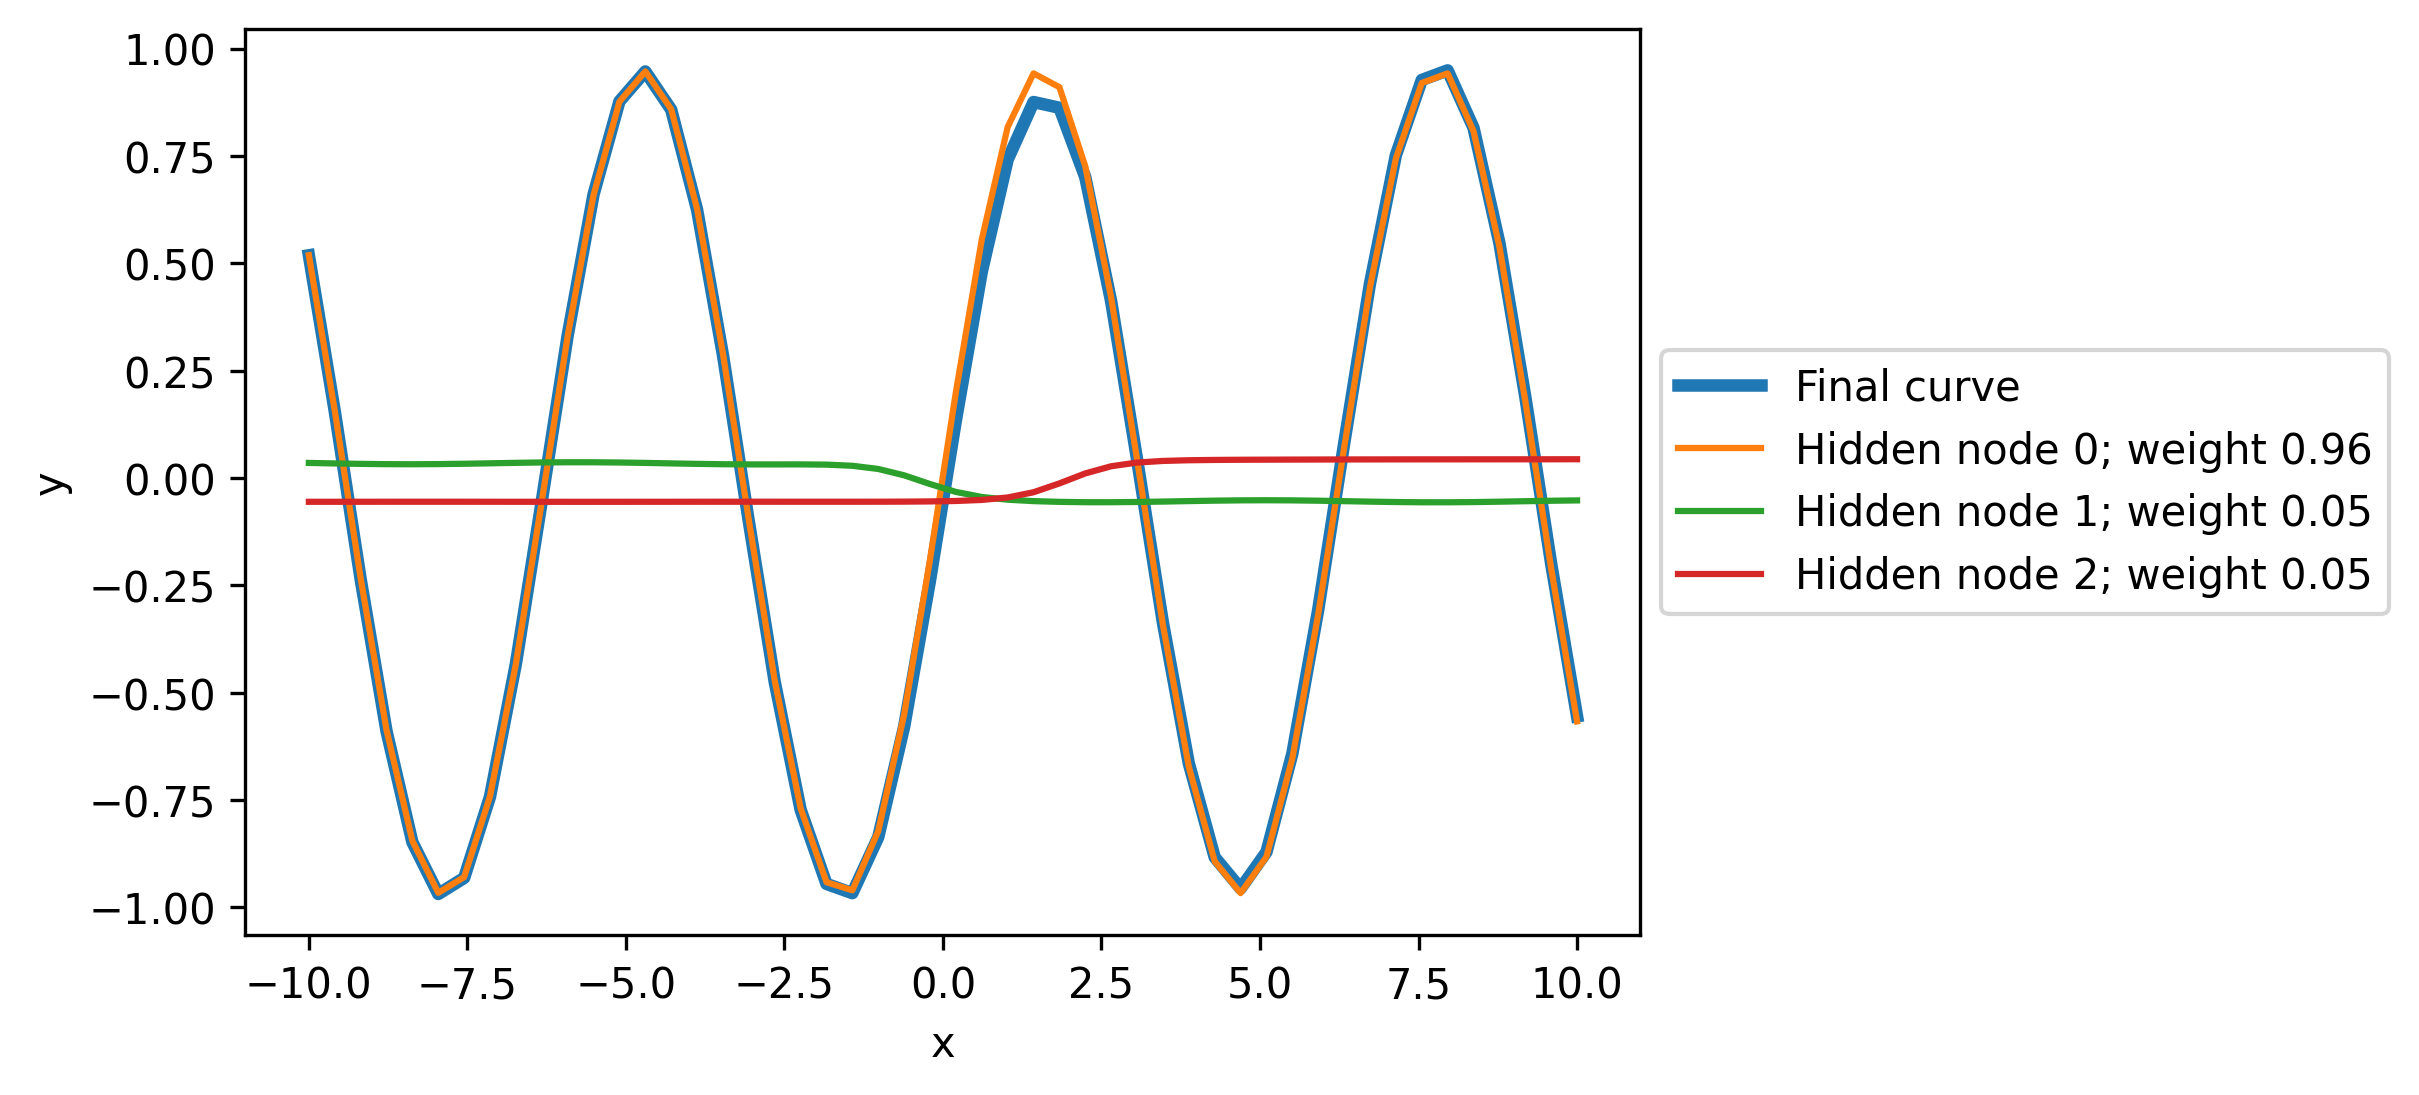

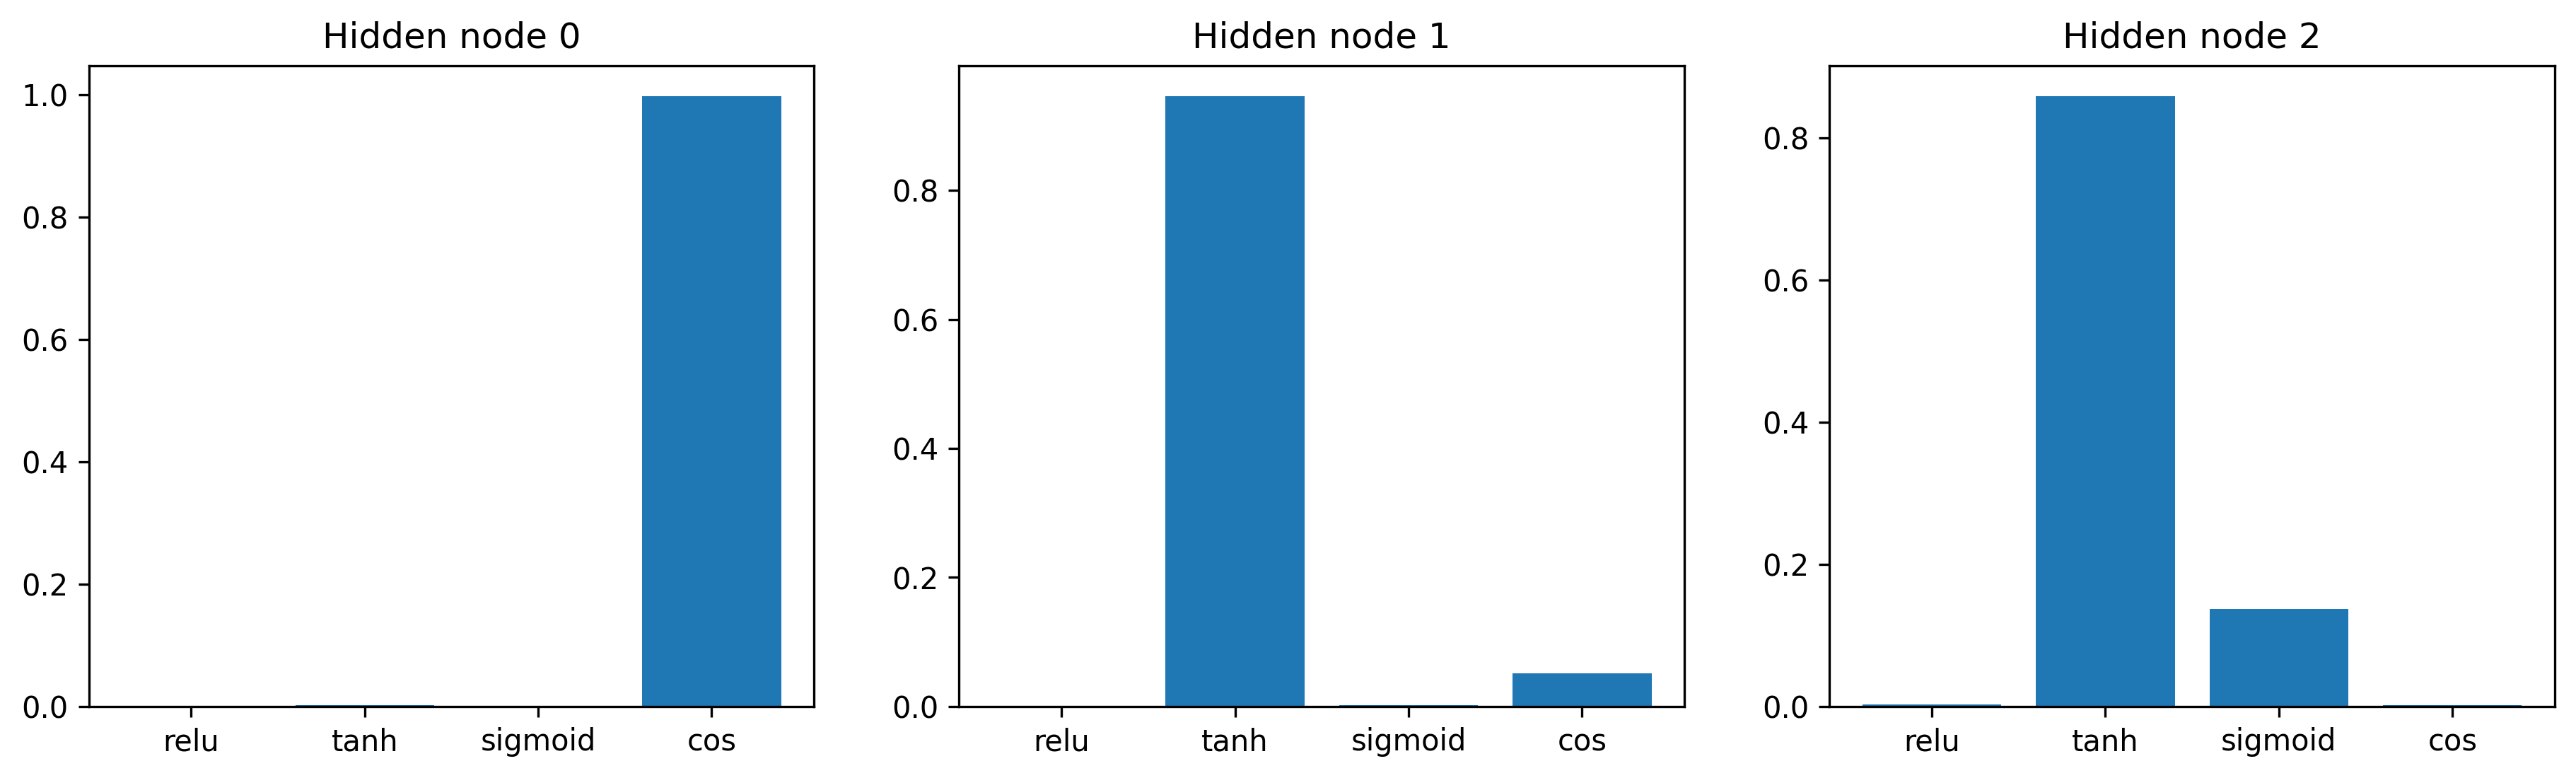

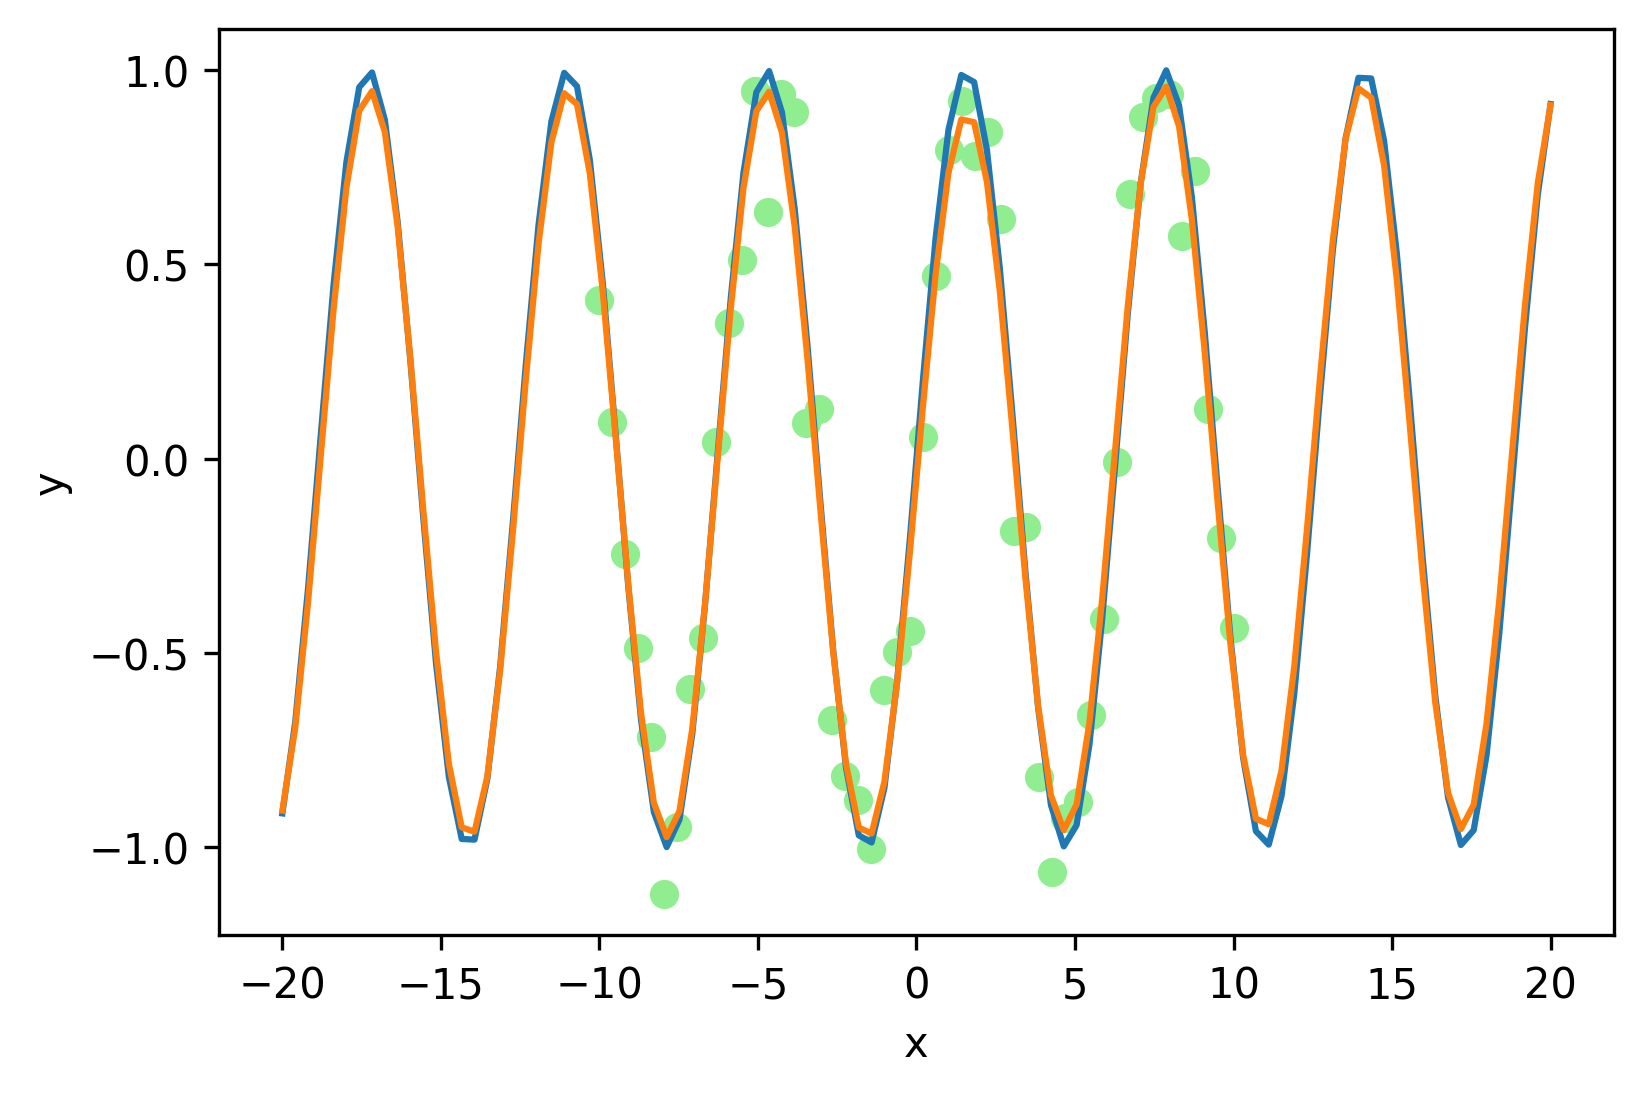

In [ ]:
run_test([keras.activations.relu, keras.activations.tanh, keras.activations.sigmoid, K.cos], n_nodes=3, iterations=100)